Kavya Bhojani


ML model to predict electricity load based on the provided
dataset, which spans approximately 5 months. The dataset includes observed and
forecasted weather data, as well as the corresponding observed load at each timestamp.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import shap

**Data Preparation**
   - Loaded and processed observed and forecasted weather data.
   - Created time-based features (dayofweek, month, is_weekend).

In [5]:
df = pd.read_csv("weatherkit_plus_load.csv")

#Basic info
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())
print("\nUnique values per column:\n", df.nunique())

#Converting timestamp and creating time-based features
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df['hour'] = df['event_timestamp'].dt.hour
df['day'] = df['event_timestamp'].dt.day
df['weekday'] = df['event_timestamp'].dt.dayofweek
df['month'] = df['event_timestamp'].dt.month
df['date'] = df['event_timestamp'].dt.date

#Daily Load Aggregates
daily_stats = df.groupby("date")["load_MW"].agg(['mean', 'min', 'max', 'std'])
print("\nDaily Aggregated Load Stats:\n", daily_stats.head())


Shape: (14298, 14)

Data types:
 event_timestamp                            object
weatherkit_observed_temperature_C         float64
weatherkit_observed_humidity_pc           float64
weatherkit_observed_air_pressure_kPa      float64
weatherkit_observed_cloud_cover_pc        float64
weatherkit_observed_wind_direction_deg    float64
weatherkit_observed_wind_speed_km_h       float64
weatherkit_forecast_temp_C                float64
weatherkit_forecast_humidity_pc           float64
weatherkit_forecast_air_pressure_kPa      float64
weatherkit_forecast_cloud_cover_pc        float64
weatherkit_forecast_wind_direction_deg    float64
weatherkit_forecast_wind_speed_km_h       float64
load_MW                                   float64
dtype: object

Missing values:
 event_timestamp                           0
weatherkit_observed_temperature_C         0
weatherkit_observed_humidity_pc           0
weatherkit_observed_air_pressure_kPa      0
weatherkit_observed_cloud_cover_pc        0
weatherkit_obse

VISUALIZATION FOR DATA UNDERSTANDING & PREP

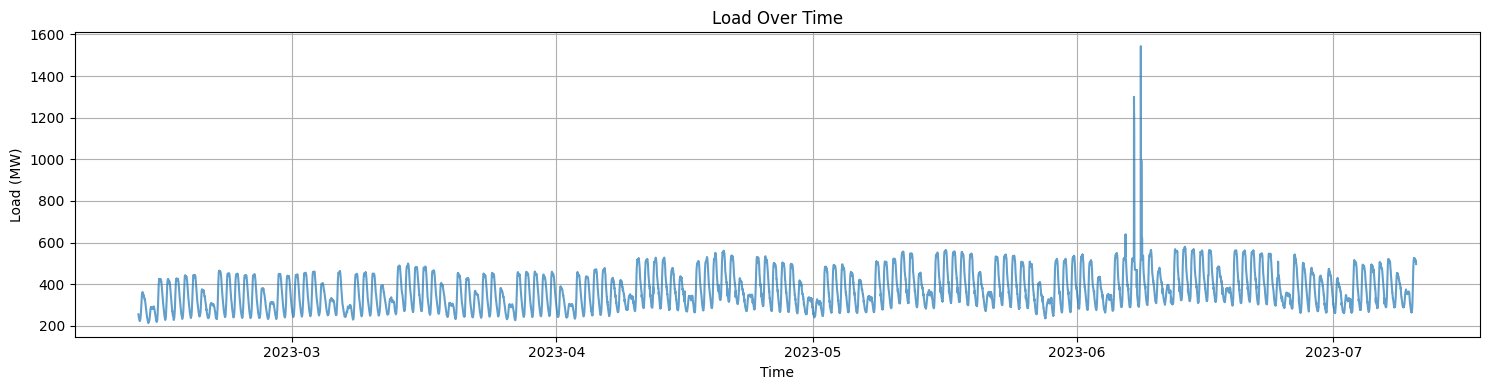

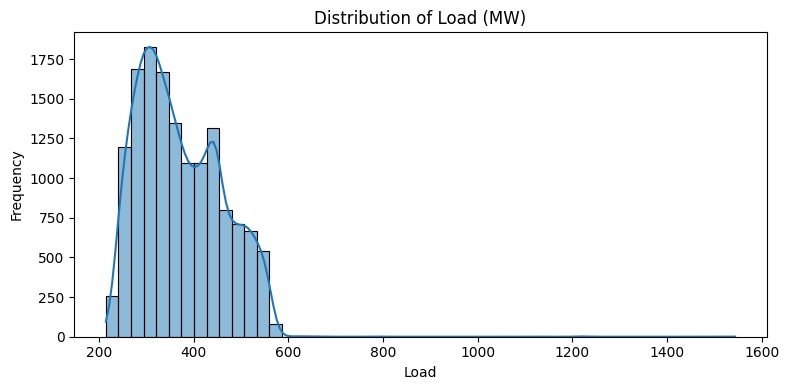

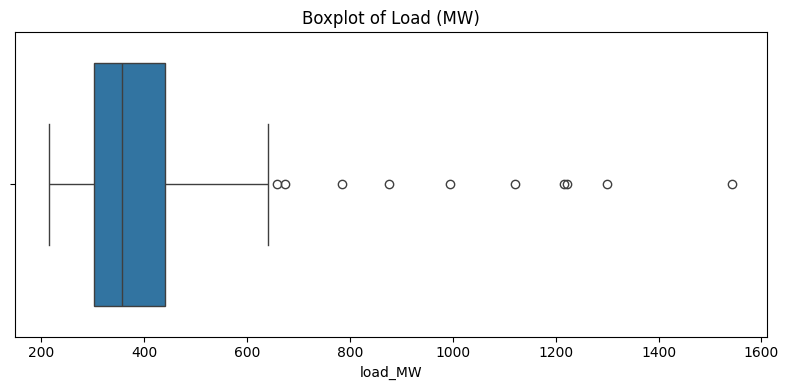

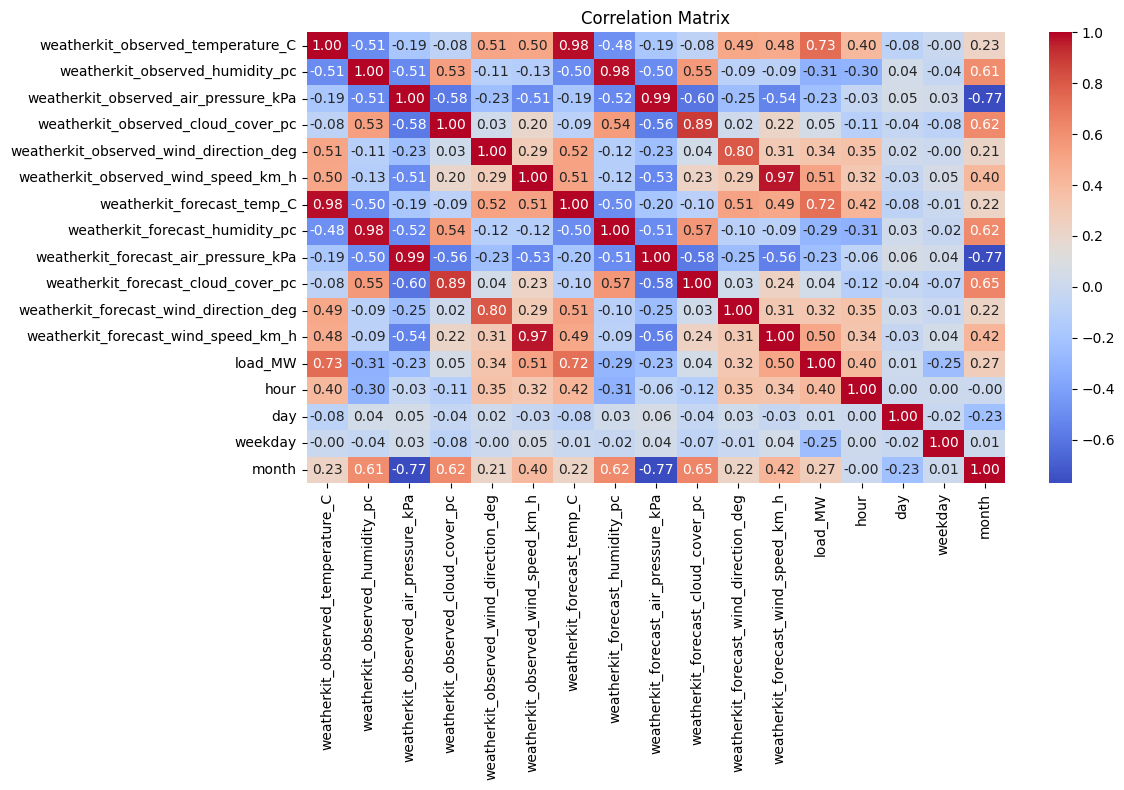

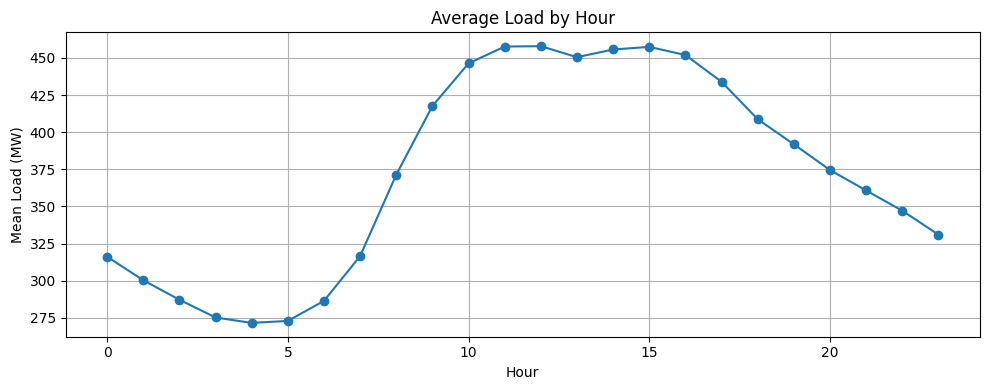

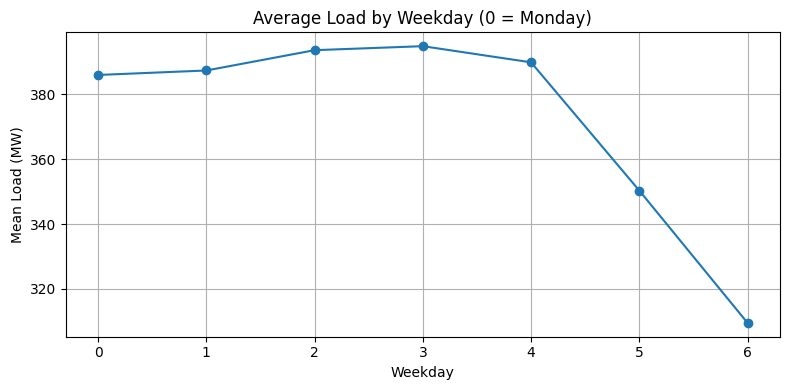

In [6]:
#Plot Load over time
plt.figure(figsize=(15, 4))
plt.plot(df['event_timestamp'], df['load_MW'], alpha=0.7)
plt.title('Load Over Time')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Distribution of Load (histogram)
plt.figure(figsize=(8, 4))
sns.histplot(df['load_MW'], kde=True, bins=50)
plt.title('Distribution of Load (MW)')
plt.xlabel('Load')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#Boxplot of Load (to check outliers)
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['load_MW'])
plt.title("Boxplot of Load (MW)")
plt.tight_layout()
plt.show()

#Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(columns=['event_timestamp', 'date']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#Average Load by Hour
plt.figure(figsize=(10, 4))
df.groupby("hour")["load_MW"].mean().plot(marker='o')
plt.title("Average Load by Hour")
plt.xlabel("Hour")
plt.ylabel("Mean Load (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

#Average Load by Weekday
plt.figure(figsize=(8, 4))
df.groupby("weekday")["load_MW"].mean().plot(marker='o')
plt.title("Average Load by Weekday (0 = Monday)")
plt.xlabel("Weekday")
plt.ylabel("Mean Load (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Feature Engineering**
   - Aggregated to daily level.
   - Added lag features, rolling window statistics, and interaction features (e.g., temp × dayofweek).

In [9]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df['date'] = pd.to_datetime(df['event_timestamp'].dt.date)

#Separate columns
forecast_cols = [col for col in df.columns if "forecast" in col]
observed_cols = [col for col in df.columns if "observed" in col]
agg_cols = forecast_cols + observed_cols

#Daily aggregation: mean, min, max, std
daily_features = df.groupby("date")[agg_cols].agg(['mean', 'min', 'max', 'std'])
daily_features.columns = ['_'.join(col).strip() for col in daily_features.columns.values]
daily_features.reset_index(inplace=True)

#Time features
daily_features['dayofweek'] = daily_features['date'].dt.dayofweek
daily_features['month'] = daily_features['date'].dt.month
daily_features['is_weekend'] = daily_features['dayofweek'].isin([5, 6]).astype(int)

#Load features
daily_load = df.groupby('date')['load_MW'].mean().reset_index()
daily_load.columns = ['date', 'load_MW_mean']
daily_features = pd.merge(daily_features, daily_load, on='date', how='left')

#Lag features
daily_features['load_MW_mean_lag1'] = daily_features['load_MW_mean'].shift(1)
daily_features['load_MW_mean_lag2'] = daily_features['load_MW_mean'].shift(2)

#Rolling averages (previous days only)
daily_features['load_MW_rolling3'] = daily_features['load_MW_mean'].shift(1).rolling(window=3).mean()
daily_features['load_MW_rolling7'] = daily_features['load_MW_mean'].shift(1).rolling(window=7).mean()

#Prediction target: next day's load
daily_features['target_load_next_day'] = daily_features['load_MW_mean'].shift(-1)

#Final clean-up
final_df = daily_features.dropna().reset_index(drop=True)

**Model Development**
   - Performed hyperparameter tuning using GridSearchCV on XGBoost.
   - Used TimeSeriesSplit cross-validation to evaluate model stability.

MAE: 18.56
RMSE: 24.14


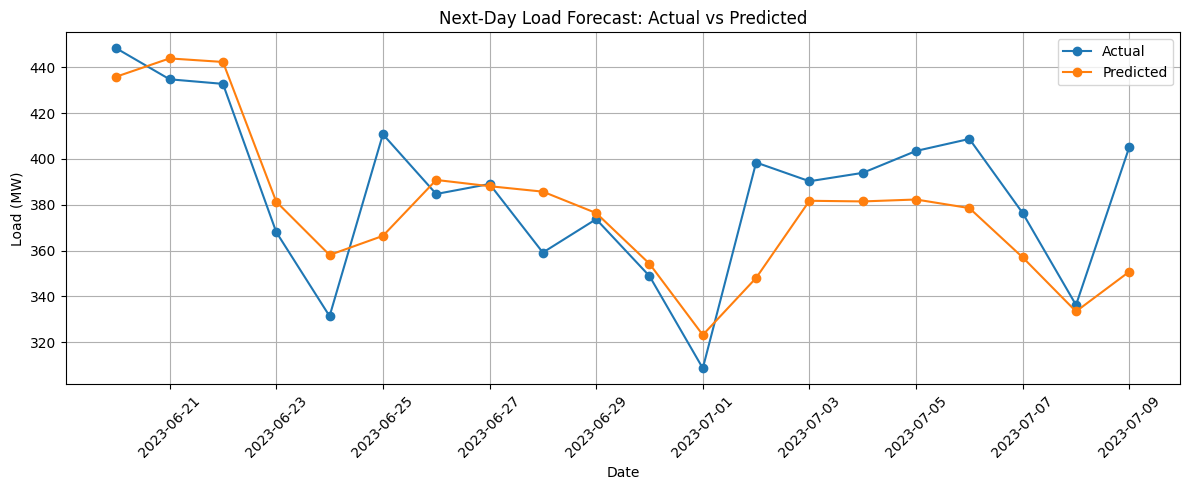

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#feature matrix
df_model = final_df.copy()
drop_cols = ['date', 'target_load_next_day', 'load_MW_mean']
X = df_model.drop(columns=drop_cols)
y = df_model['target_load_next_day']

#Split time-based (last 20 days for test)
split_date = df_model['date'].iloc[-20]
train_idx = df_model['date'] < split_date
test_idx = df_model['date'] >= split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

#Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#Training params
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

#early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = model.predict(dtest)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

#actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df_model['date'][test_idx], y_test.values, label="Actual", marker='o')
plt.plot(df_model['date'][test_idx], y_pred, label="Predicted", marker='o')
plt.title("Next-Day Load Forecast: Actual vs Predicted")
plt.ylabel("Load (MW)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE

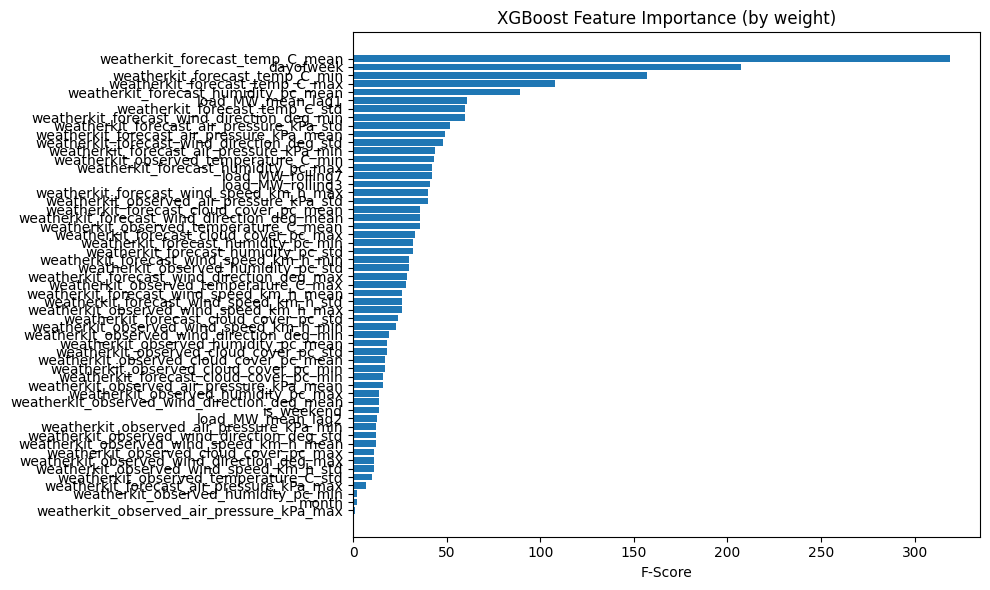

In [13]:
#raw scores
importance = model.get_score(importance_type='weight')
importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(list(importance.keys())[::-1], list(importance.values())[::-1])
plt.title("XGBoost Feature Importance (by weight)")
plt.xlabel("F-Score")
plt.tight_layout()
plt.show()

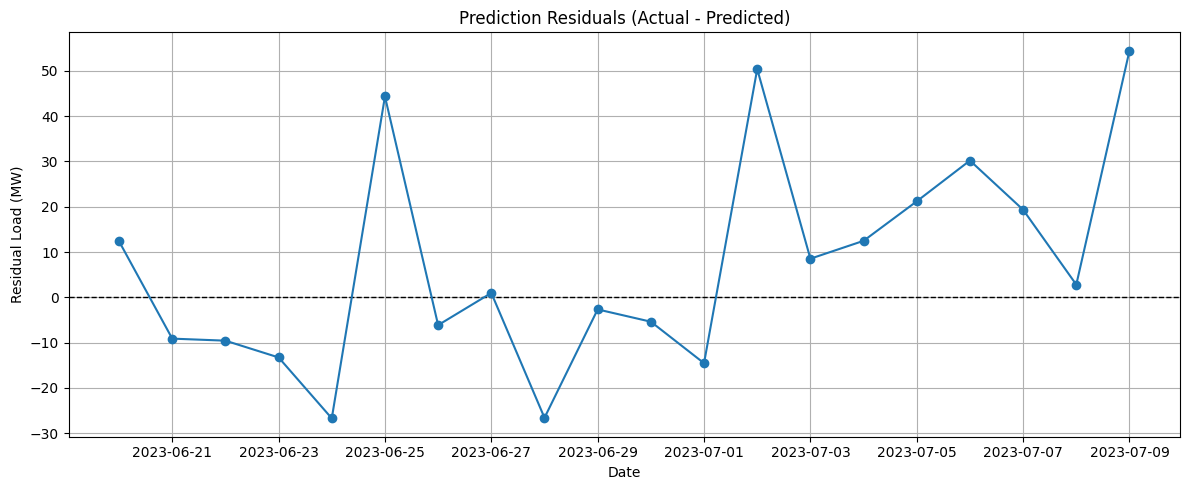

In [14]:
#Residuals = Actual - Predicted
residuals = y_test.values - y_pred

plt.figure(figsize=(12, 5))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.plot(df_model['date'][test_idx], residuals, marker='o')
plt.title("Prediction Residuals (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Residual Load (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

HYPER PARAM TUNING

In [16]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#Redefine input for sklearn estimator
X = df_model.drop(columns=['date', 'target_load_next_day', 'load_MW_mean'])
y = df_model['target_load_next_day']

#same train-test split logic
split_date = df_model['date'].iloc[-20]
train_idx = df_model['date'] < split_date
test_idx = df_model['date'] >= split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

xgb_estimator = XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42)

#Grid for search
param_grid = {
    "max_depth": [4, 6],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [200, 400],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

#Run grid search
grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1
)
grid_search.fit(X_train, y_train)

#best config
print("Best params:", grid_search.best_params_)
print("Best CV score (neg MAE):", grid_search.best_score_)

#Retrain using best config
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
print(f"Tuned MAE: {mae_tuned:.2f}")
print(f"Tuned RMSE: {rmse_tuned:.2f}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'subsample': 1.0}
Best CV score (neg MAE): -18.94685966744294
Tuned MAE: 13.77
Tuned RMSE: 17.26


**Rolling Forecast Simulation**
   - Built a day-by-day forecasting loop to simulate predictions made at 8:00 AM for the next day's load.
   - Evaluated model under real-world deployment constraints.

[Rolling] MAE: 24.82
[Rolling] RMSE: 30.06


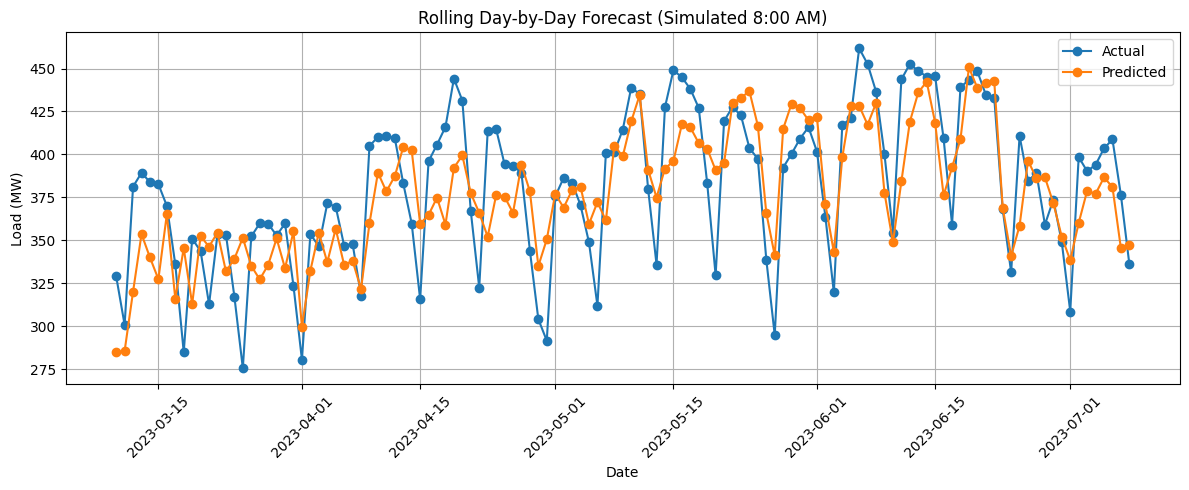

In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Sort dataframe by date
df_sorted = final_df.sort_values("date").reset_index(drop=True)

drop_cols = ['date', 'target_load_next_day', 'load_MW_mean']
feature_cols = [col for col in df_sorted.columns if col not in drop_cols]

#Rolling prediction setup
start_idx = 20  # starting from day 20 to ensure rolling features exist
predictions = []
actuals = []
prediction_dates = []

#Initialize model with best params from tuning
model = XGBRegressor(
    objective='reg:squarederror',
    max_depth=4,
    learning_rate=0.05,
    n_estimators=400,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

#Rolling prediction loop
for i in range(start_idx, len(df_sorted) - 1):
    train_df = df_sorted.iloc[:i]
    test_row = df_sorted.iloc[[i]]  # predict next day using today's info
    y_true = df_sorted.iloc[i]['target_load_next_day']

    X_train = train_df[feature_cols]
    y_train = train_df['target_load_next_day']
    X_test = test_row[feature_cols]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_true)
    prediction_dates.append(df_sorted.iloc[i]['date'])

mae_roll = mean_absolute_error(actuals, predictions)
rmse_roll = np.sqrt(mean_squared_error(actuals, predictions))
print(f"[Rolling] MAE: {mae_roll:.2f}")
print(f"[Rolling] RMSE: {rmse_roll:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(prediction_dates, actuals, label="Actual", marker='o')
plt.plot(prediction_dates, predictions, label="Predicted", marker='o')
plt.title("Rolling Day-by-Day Forecast (Simulated 8:00 AM)")
plt.ylabel("Load (MW)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

#Using same X and y as final_df prepped earlier
tscv = TimeSeriesSplit(n_splits=5)

# Redefine model if needed
model_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    max_depth=4,
    learning_rate=0.05,
    n_estimators=400,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

scores = cross_val_score(model_xgb, X, y, cv=tscv, scoring='neg_mean_absolute_error')

print(f"Average Cross-Validation MAE: {abs(np.mean(scores)):.2f}")
print(f"Cross-Validation MAEs: {abs(scores)}")

Average Cross-Validation MAE: 27.76
Cross-Validation MAEs: [21.44401319 46.25711281 27.79071104 26.82846412 16.4639553 ]


**Evaluation and Explainability**
   - Reported MAE, RMSE, MAPE, and approximate accuracy.
   - Used SHAP to interpret feature importance and model decision logic.

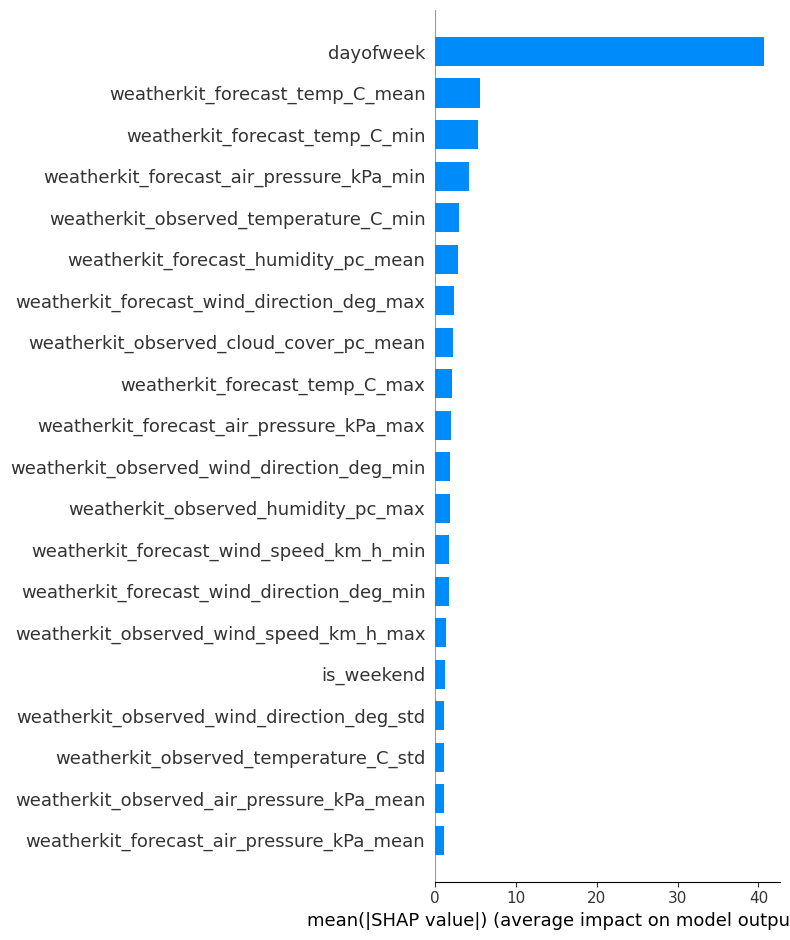

In [23]:
from xgboost import XGBRegressor

#Training again on full training data
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=4,
    learning_rate=0.05,
    n_estimators=400,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train, y_train)

explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

SUMMARY

- Developed a next-day electricity load forecasting model using forecasted weather data and time features.
- The tuned XGBoost model achieved **MAE of 13.77 MW** and **MAPE of 4.55%** (approximately **95.45% accuracy**).
- A rolling daily forecast simulation produced **MAE of 24.82 MW**, proving the model's real-world robustness.
- SHAP analysis confirmed that **forecasted temperature**, **day of the week**, and **humidity** were the most influential features.
- Cross-validation with TimeSeriesSplit showed acceptable variance across time folds, reflecting seasonal behavior.
- The model respects the **8:00 AM prediction constraint** and is suitable for daily production deployment.
- **Final recommendation:** Deploy the tuned XGBoost model with daily retraining and monitor performance periodically for drift.
